In [12]:
%matplotlib inline
import wave

from time import time

import numpy as np

import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.datasets import fetch_olivetti_faces
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score

# <center>TP n° 8: ICA, PCA, NMF</center> 

## - Introduction -

#### 1) Étudier le script ica_audio.py et l'utiliser pour générer le mélange stéréo. Prendre le temps d'écouter les différents signaux.

In [2]:
import wave

import matplotlib.pyplot as plt
import numpy as np

from sklearn import decomposition

# -- Read audio data ----------------------------------------------------------


def wavread(filename):
    """Read .wav file"""
    wf = wave.open(filename)
    s = np.fromstring(wf.readframes(wf.getnframes()), dtype=np.int16)
    wf.close()
    return s


def wavwrite(filename, s, nchannels=1):
    """Write .wav file"""
    wf = wave.open(filename, 'wb')
    wf.setnchannels(nchannels)
    wf.setsampwidth(2)
    wf.setframerate(32000)
    s = s / np.max(np.abs(s)) * 2 ** 14  # normalise arbitrarily
    wf.writeframes(s.astype(np.int16).tostring())
    wf.close()


In [13]:
# -- Import audio data --------------------------------------------------------
s1 = wavread('./snd/es02.wav')
s2 = wavread('./snd/si01.wav')

# -- Create stereo mix --------------------------------------------------------
nsmp = min(len(s1), len(s2))
s1 = s1[:nsmp]
s2 = s2[:nsmp]
S = np.c_[s1, s2]
# Mixing matrix
A = np.array([[0.6, 0.5],
             [0.4, 0.5]])
# Do the mix
X = S.dot(A)
# Write mix file
x = np.zeros(2 * nsmp)
x[::2] = X[:, 0]
x[1::2] = X[:, 1]
wavwrite('./snd/mix.wav', x, nchannels=2)

#### 2) Utiliser l'ICA pour extraire les sources originales à partir du mélange. On exploitera pour cela sklearn.decomposition.FastICA.

In [5]:
from numpy import linalg

In [6]:
# -- ICA source separation ----------------------------------------------------
from sklearn.decomposition import FastICA
ICA = FastICA(n_components=2)
X_new = ICA.fit_transform(X)

# Visualise sources

# Write audio sources
X_new
source_1 = X_new[:,0]
source_2 = X_new[:,1]

wavwrite('./snd/mix_sourc1.wav', source_1, nchannels=1)
wavwrite('./snd/mix_sourc2.wav', source_2, nchannels=1)

##  <center></center>    
##  <center>- Extraction de caractéristiques de visages -</center> 

#### 1) Étudier et tester le script pca_nmf_faces.py. Analyser le type de décomposition obtenu par NMF en comparaison avec celui obtenu par PCA.

Dataset consists of 400 faces
n


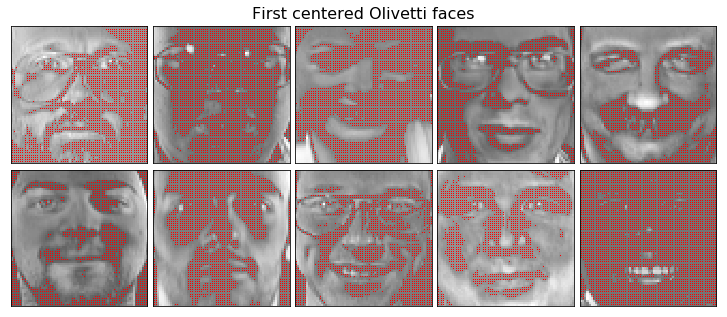

In [17]:
from time import time

import matplotlib.pyplot as plt

import numpy as np
from numpy.random import RandomState

from sklearn import decomposition
from sklearn.datasets import fetch_olivetti_faces

# -- Prepare data and define utility functions --------------------------------

n_row, n_col = 2, 5
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0, dtype=np.float64)

print ("Dataset consists of %d faces" % n_samples)
print("n")


def plot_gallery(title, images):
    """Plot images as gallery"""
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        comp = comp.reshape(image_shape)
        vmax = comp.max()
        vmin = comp.min()
        dmy = np.nonzero(comp < 0)
        if len(dmy[0]) > 0:
            yz, xz = dmy
        comp[comp < 0] = 0

        plt.imshow(comp, cmap=plt.cm.gray, vmax=vmax, vmin=vmin)

        if len(dmy[0]) > 0:
            plt.plot(xz, yz, 'r,')
            #print(len(dmy[0]), "negative-valued pixels")

        plt.xticks(())
        plt.yticks(())

    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

# Plot a sample of the input data
plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

# -- Decomposition methods ----------------------------------------------------




In [15]:
# List of the different estimators and whether to center the data

estimators = [
    ('pca', 'Eigenfaces - PCA',
     decomposition.PCA(n_components=n_components, whiten=True),
     True),

    ('nmf', 'Non-negative components - NMF',
     decomposition.NMF(n_components=n_components, init=None, tol=1e-6,
                       sparseness=None, max_iter=1000),
     False)
]

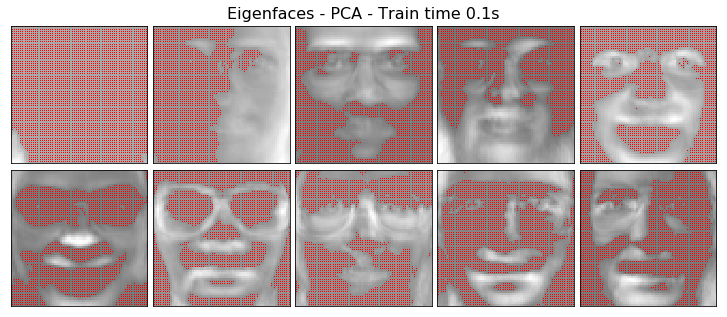

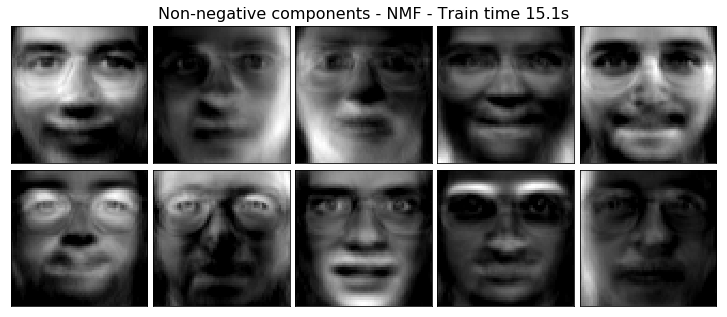

In [18]:
# -- Transform and classify ---------------------------------------------------

labels = dataset.target
X = faces
X_ = faces_centered

for shortname, name, estimator, center in estimators:
    #print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()

    data = X
    if center:
        data = X_

    data = estimator.fit_transform(data)
    train_time = (time() - t0)
    components_ = estimator.components_

    plt.figure;
    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components]);

    plt.show();

La décomposition par PCA renvoie des valeurs potentiellement négatives (pixels rouges). Dans le cadre de d'une analyze d'images cela fait perdre en interprétabilité (pixels négatifs) : il est difficile d'associer une importance par zones pour chaque image de la décomposition. La NMF en contraignant les vecteurs propres à avoir des valeures positives est plus interprétable dans de cadre là. Elle a cependant un coût en terme de temps d'apprentissage est bien plus impotant. 

#### 2) Modier le script pour réaliser une évaluation des performances d'un système de reconnaissance automatique de visages utilisant les caractéristiques extraites par PCA, comparées à celles obtenues par un système exploitant les caractéristiques extraites par NMF. On pourra utiliser la LDA pour la classication. On eectuera l'évaluation par validation croisée. On observera l'évolution des scores en faisant varier le nombre de composantes utilisé dans les décompositions.

In [96]:
score_pca = []
score_nmf = []

for n_components1 in [1,5,10,20,50]:
    data_pca = X_
    data_nmf = X
    y = labels
    pca = decomposition.PCA(n_components=n_components1, whiten=True)   
    data_pca = pca.fit_transform(data_pca)

    nmf = decomposition.NMF(n_components=n_components1, init=None, tol=1e-6,sparseness=None, max_iter=1000)   
    data_nmf = nmf.fit_transform(data_nmf)
    
    lda = LDA(solver='svd',n_components=None)

    score_pca.append(cross_val_score(lda, data_pca, y,cv=3).mean())
    score_nmf.append(cross_val_score(lda, data_nmf, y,cv=3).mean())

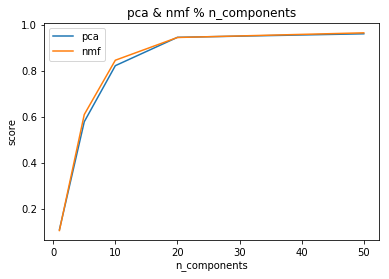

In [102]:
plt.plot([1,5,10,20,50],score_pca,label='pca')
plt.plot([1,5,10,20,50],score_nmf,label='nmf')
plt.xlabel('n_components')
plt.ylabel('score')
plt.title('pca & nmf % n_components')
plt.legend()

#### Conclusion:  
Les performances en terme de score sont trés similaires entre les deux méthodes. Le choix de l'une ou l'autre des méthodes se fera en arbitrant sur l'interprétabilité (en préférant la NMF) ou le temps de calcul (en préférant une PCA).